In [70]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# We will use 'smf' for the mixed-effects model formula
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import scipy.stats as stats
import itertools

from statannotations.Annotator import Annotator

preprocessing

In [71]:
data_df = pd.read_excel('../data/qqs_plant_roots_data.xlsx', header=1)

df = data_df.copy()

if 'Name' in df.columns:
    df['Name'] = df['Name'].astype(str).str.strip()
else:
    print("Error: 'Name' column not found.")
    df['Name'] = pd.Series(dtype=str)

df.dropna(subset=['Name'], inplace=True)
df = df[~df['Name'].str.contains('Note:', na=False)]
df.rename(columns={'Name': 'Transgenic_Line'}, inplace=True)

# --- 2. Create Pot-Level Outcome Variables ---
print("--- Creating Pot-Level Data ---")
valid_lines = ['EV', 'WT', 'QQS-3', 'QQS-5', 'QQS-7', 'QQS-10']
df = df[df['Transgenic_Line'].isin(valid_lines)].copy()
df = df.reset_index().rename(columns={'index': 'Pot_ID'})

value_vars = []
if 'Individule Root Weight (g)' in df.columns:
    value_vars.append('Individule Root Weight (g)')
value_vars.extend([col for col in df.columns if 'Unnamed:' in str(col)])

if not value_vars:
     print("Warning: No root weight columns found.")
     df['Total_Weight'] = 0
     df['Number_of_Roots'] = 0
else:
    df['Total_Weight'] = df[value_vars].sum(axis=1)
    df['Number_of_Roots'] = df[value_vars].count(axis=1)

pot_df = df[['Pot_ID', 'Transgenic_Line', 'Total_Weight', 'Number_of_Roots']].copy()
pot_df['Transgenic_Line'] = pot_df['Transgenic_Line'].astype('category')

print("Cleaned pot-level dataframe created:")
if len(pot_df) > 0:
    print(f"\nTotal pots in analysis: {len(pot_df)}")
    print(pot_df['Transgenic_Line'].value_counts())
else:
    print("No valid data found after filtering.")

# Save the dataframe to be used by the next script
pot_df.to_csv('pot_level_data.csv', index=False)
print("\nPreprocessing complete. Saved 'pot_level_data.csv'.")

--- Creating Pot-Level Data ---
Cleaned pot-level dataframe created:

Total pots in analysis: 20
Transgenic_Line
QQS-10    5
EV        3
QQS-3     3
QQS-5     3
QQS-7     3
WT        3
Name: count, dtype: int64

Preprocessing complete. Saved 'pot_level_data.csv'.


stats

In [72]:
# --- 3. Pairwise T-Tests ---
print("\n--- Running Pairwise T-Tests ---")

if 'Transgenic_Line' in pot_df.columns and len(pot_df['Transgenic_Line'].unique()) > 1:
    pot_df['Transgenic_Line'] = pot_df['Transgenic_Line'].astype(str)
    unique_lines = pot_df['Transgenic_Line'].unique()
    
    line_pairs = list(itertools.combinations(unique_lines, 2))
    n_comparisons = len(line_pairs)
    print(f"Comparing {len(unique_lines)} groups, leading to {n_comparisons} pairwise comparisons.")
    print(f"Applying Bonferroni correction (alpha = 0.05 / {n_comparisons}).")

    # --- T-Tests for Total_Weight ---
    ttest_results_weight = []
    for line1, line2 in line_pairs:
        data1 = pot_df[pot_df['Transgenic_Line'] == line1]['Total_Weight']
        data2 = pot_df[pot_df['Transgenic_Line'] == line2]['Total_Weight']
        t_stat, pvalue = stats.ttest_ind(data1, data2, equal_var=False) # Welch's T-test
        ttest_results_weight.append((line1, line2, pvalue))
    
    ttest_df_weight = pd.DataFrame(ttest_results_weight, columns=['line1', 'line2', 'pvalue'])
    ttest_df_weight['p_adj'] = ttest_df_weight['pvalue'] * n_comparisons
    ttest_df_weight['p_adj'] = ttest_df_weight['p_adj'].clip(upper=1.0)
    ttest_df_weight['significant'] = ttest_df_weight['p_adj'] < 0.05
    
    print("\n--- T-Test Results for Total_Weight (Bonferroni Adjusted) ---")
    print(ttest_df_weight[ttest_df_weight['significant']])

    # --- T-Tests for Number_of_Roots ---
    ttest_results_roots = []
    for line1, line2 in line_pairs:
        data1 = pot_df[pot_df['Transgenic_Line'] == line1]['Number_of_Roots']
        data2 = pot_df[pot_df['Transgenic_Line'] == line2]['Number_of_Roots']
        t_stat, pvalue = stats.ttest_ind(data1, data2, equal_var=False)
        ttest_results_roots.append((line1, line2, pvalue))

    ttest_df_roots = pd.DataFrame(ttest_results_roots, columns=['line1', 'line2', 'pvalue'])
    ttest_df_roots['p_adj'] = ttest_df_roots['pvalue'] * n_comparisons
    ttest_df_roots['p_adj'] = ttest_df_roots['p_adj'].clip(upper=1.0)
    ttest_df_roots['significant'] = ttest_df_roots['p_adj'] < 0.05

    print("\n--- T-Test Results for Number_of_Roots (Bonferroni Adjusted) ---")
    print(ttest_df_roots[ttest_df_roots['significant']])
else:
    print("Not enough data or groups to compare. Skipping t-tests.")
    ttest_df_weight = pd.DataFrame(columns=['line1', 'line2', 'pvalue', 'p_adj', 'significant'])
    ttest_df_roots = pd.DataFrame(columns=['line1', 'line2', 'pvalue', 'p_adj', 'significant'])

# Save results for the plotting script
ttest_df_weight.to_csv('ttest_results_weight.csv', index=False)
ttest_df_roots.to_csv('ttest_results_roots.csv', index=False)

print("\nStats analysis complete. Saved t-test results.")


--- Running Pairwise T-Tests ---
Comparing 6 groups, leading to 15 pairwise comparisons.
Applying Bonferroni correction (alpha = 0.05 / 15).

--- T-Test Results for Total_Weight (Bonferroni Adjusted) ---
Empty DataFrame
Columns: [line1, line2, pvalue, p_adj, significant]
Index: []

--- T-Test Results for Number_of_Roots (Bonferroni Adjusted) ---
   line1   line2    pvalue     p_adj  significant
2  QQS-3  QQS-10  0.002595  0.038929         True

Stats analysis complete. Saved t-test results.


plotting

Generating 'total_weight_barplot.png'...
No significant pairs to annotate for Total Weight.
Saved 'total_weight_barplot.png'
Generating 'number_of_roots_barplot.png'...
Annotating 1 significant pairs for Number of Roots.


/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/1860722167.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Transgenic_Line', y='Total_Weight', data=pot_df,
/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/1860722167.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Transgenic_Line', y='Number_of_Roots', data=pot_df,


KeyError: 0

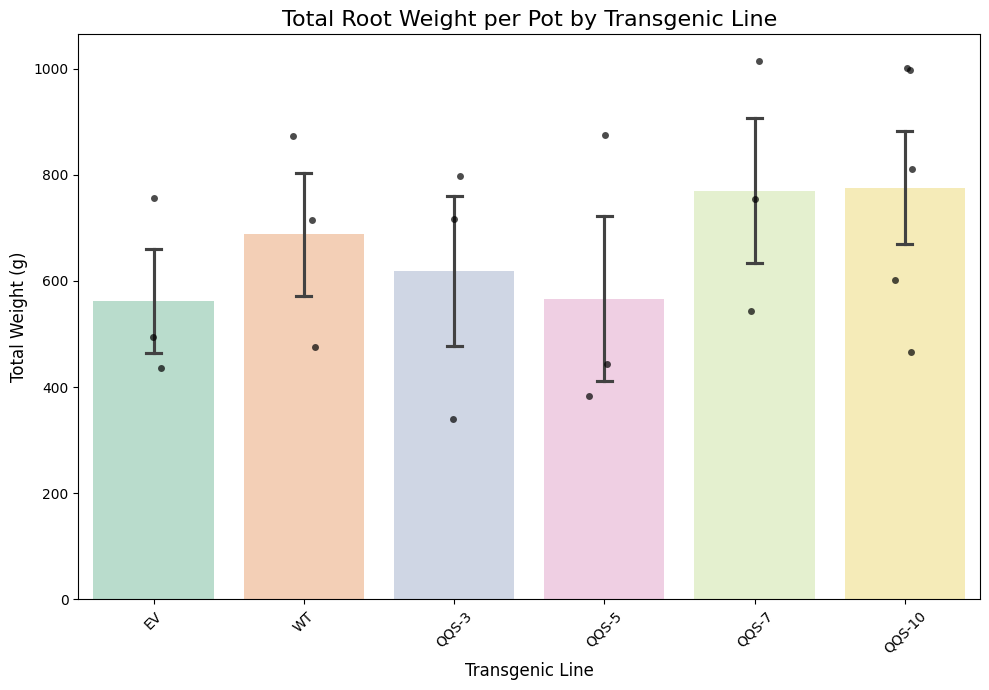

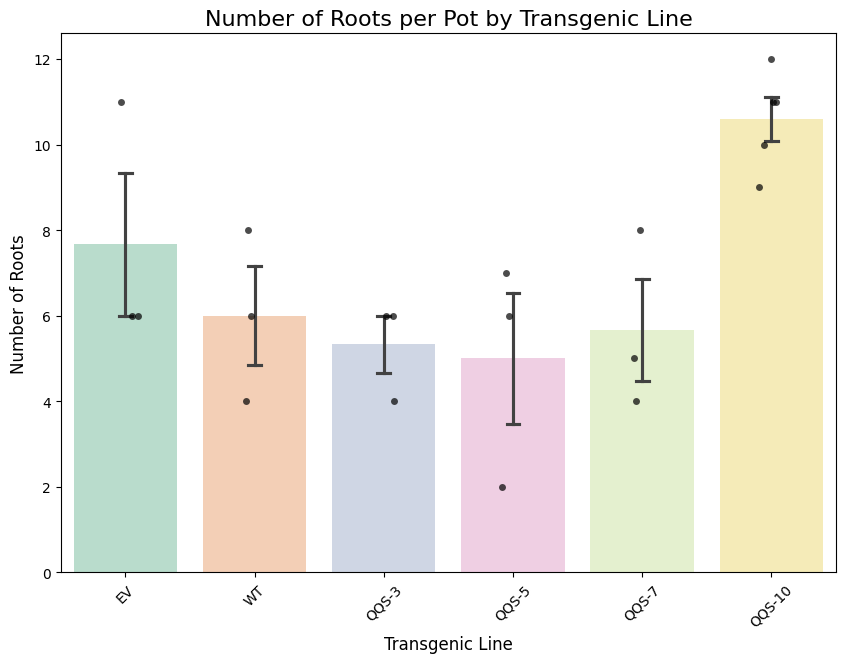

In [ ]:
# Define a consistent order and color palette
plot_order = ['EV', 'WT', 'QQS-3', 'QQS-5', 'QQS-7', 'QQS-10']
palette = "Pastel2"
stripplot_color = "black"

# --- Plot 1: Total Weight Bar Plot ---
print("Generating 'total_weight_barplot.png'...")
plt.figure(figsize=(10, 7))
ax1 = sns.barplot(x='Transgenic_Line', y='Total_Weight', data=pot_df, 
                    order=plot_order, palette=palette, 
                    capsize=0.1, errorbar='se') # Use standard error

sns.stripplot(x='Transgenic_Line', y='Total_Weight', data=pot_df, 
                order=plot_order, color=stripplot_color, 
                jitter=True, alpha=0.7, ax=ax1)

ax1.set_title('Total Root Weight per Pot by Transgenic Line', fontsize=16)
ax1.set_ylabel('Total Weight (g)', fontsize=12)
ax1.set_xlabel('Transgenic Line', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Add statistical annotations
sig_pairs_weight = ttest_df_weight[ttest_df_weight['significant']]
pairs = list(zip(sig_pairs_weight['line1'], sig_pairs_weight['line2']))

if not pairs:
    print("No significant pairs to annotate for Total Weight.")
else:
    print(f"Annotating {len(pairs)} significant pairs for Total Weight.")
    p_values = sig_pairs_weight['p_adj'].reset_index(drop=True)
    
    annotator = Annotator(ax1, pairs, data=pot_df, 
                            x='Transgenic_Line', y='Total_Weight', 
                            order=plot_order)
    annotator.configure(text_format='star', loc='inside', verbose=False)
    annotator.set_pvalues_and_annotate(p_values)

plt.tight_layout()
plt.savefig('total_weight_barplot.png')
print("Saved 'total_weight_barplot.png'")

# --- Plot 2: Number of Roots Bar Plot ---
print("Generating 'number_of_roots_barplot.png'...")
plt.figure(figsize=(10, 7))
ax2 = sns.barplot(x='Transgenic_Line', y='Number_of_Roots', data=pot_df, 
                    order=plot_order, palette=palette, 
                    capsize=0.1, errorbar='se') # Use standard error

sns.stripplot(x='Transgenic_Line', y='Number_of_Roots', data=pot_df, 
                order=plot_order, color=stripplot_color, 
                jitter=True, alpha=0.7, ax=ax2)

ax2.set_title('Number of Roots per Pot by Transgenic Line', fontsize=16)
ax2.set_ylabel('Number of Roots', fontsize=12)
ax2.set_xlabel('Transgenic Line', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Add statistical annotations
sig_pairs_roots = ttest_df_roots[ttest_df_roots['significant']]
pairs_roots = list(zip(sig_pairs_roots['line1'], sig_pairs_roots['line2']))

if not pairs_roots:
    print("No significant pairs to annotate for Number of Roots.")
else:
    print(f"Annotating {len(pairs_roots)} significant pairs for Number of Roots.")
    p_values_roots = sig_pairs_roots['p_adj'].reset_index(drop=True)
    
    annotator_roots = Annotator(ax2, pairs_roots, data=pot_df, 
                                x='Transgenic_Line', y='Number_of_Roots', 
                                order=plot_order)
    annotator_roots.configure(text_format='star', loc='inside', verbose=False)
    annotator_roots.set_pvalues_and_annotate(p_values_roots)

plt.tight_layout()
plt.savefig('number_of_roots_barplot.png')
print("Saved 'number_of_roots_barplot.png'")
print("\nPlotting complete.")